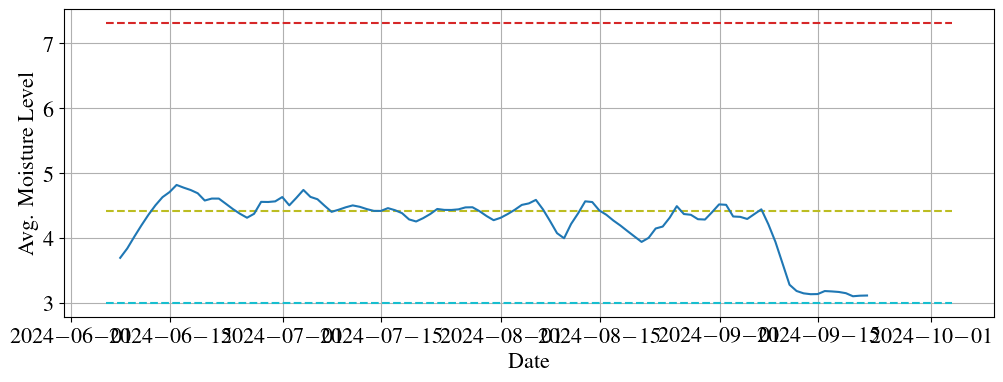

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import log as ln

plt.rcParams.update({'font.size': 16, 'font.family': 'Times'})
plt.rcParams['text.usetex'] = True

df = pd.read_csv('/home/field_data/ancarani_attuale_ottimo_T0_T1-1.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.sort_values('timestamp')
fig, axs = plt.subplots(1, 1, figsize=(12, 4), sharex=True)
df["Field capacity"] = ln(np.abs(-20))
df["Dry"] = ln(np.abs(-300))
df["Very dry"] = ln(np.abs(-1500))
subset = df[df['plantRow'] == "T0 alto"]
subset["optimal"] = subset["optimal"].iloc[0]
line4, = axs.plot(subset['timestamp'], subset['optimal'], label="Optimal", color="tab:olive", ls="--")
subset = df[df['plantRow'] == "T1 alto"]

def impute_with_rolling_average(df, column_name, window_size=4):
  df[column_name] = df[column_name].fillna(df[column_name].rolling(window=window_size, min_periods=1).mean())
  return df

def rolling(df, window_size=4, column="actual"):
  df[column] = df[column].rolling(window=window_size, center=True).mean()

rolling(subset)

line1, = axs.plot(subset['timestamp'], subset['actual'], label="SMARTER", color="tab:blue", ls="-")
line2, = axs.plot(df['timestamp'], df['Field capacity'], label=f'Field capacity', color="tab:cyan", ls="--")
line3, = axs.plot(df['timestamp'], df['Very dry'], label=f'Permanent wilting point', color="tab:red", ls="--")
axs.set_xlabel('Date')
axs.set_ylabel('Avg. Moisture Level')
axs.grid(True)
plt.setp(axs.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")
print()

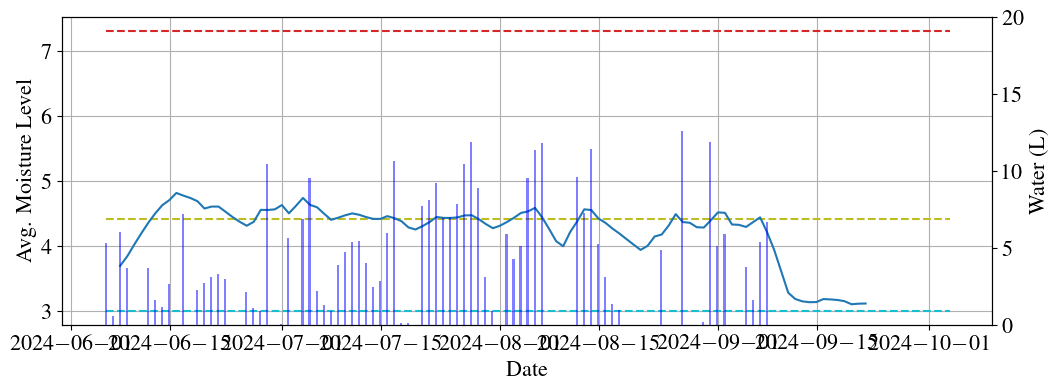

In [175]:
df = pd.read_csv('/home/field_data/ancarani_r_advice_timestamp.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.sort_values('timestamp')


ax2 = axs.twinx()
bar_width, offset = 0.3, 3.6
ax2.bar(df["timestamp"] - pd.Timedelta(hours=offset), df["dripper"], bar_width, label='Irrigation', color='blue', alpha=0.5)
ax2.set_ylabel('Water (L)')
ax2.tick_params(axis='y')
ax2.set_ylim([0, 20])

fig

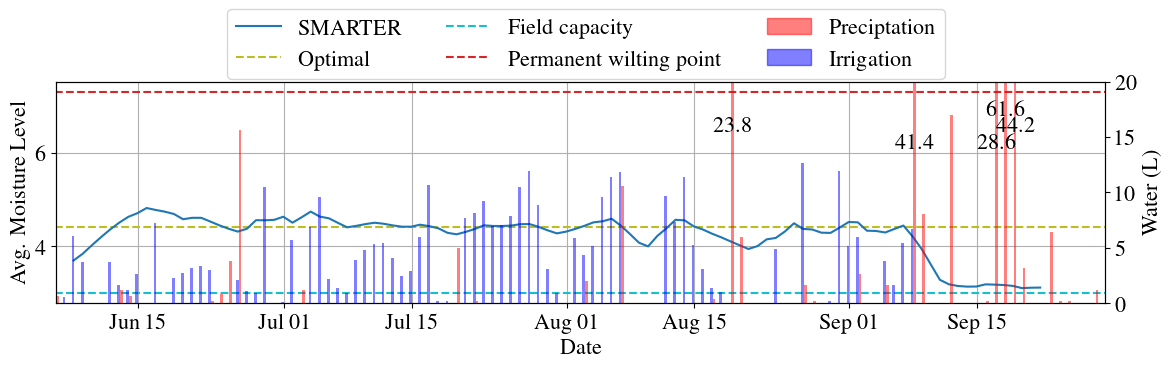

In [176]:

import matplotlib.dates as mdates
persist=True

def save(fig, f, persist=True):
  for ext in ['svg', 'pdf']:
    fig.savefig(f'/home/results/{f}.{ext}')

df_piogge = pd.read_csv('/home/field_data/ancarani_piogge.csv')
df_piogge['timestamp'] = pd.to_datetime(df_piogge['timestamp'], unit='s')
df_piogge = df_piogge.sort_values('timestamp')
df_piogge[df_piogge["sum"] > 20].apply(lambda dff: ax2.text(dff["timestamp"] + pd.Timedelta(hours=offset), 17 - 1.5 * (dff["timestamp"].day % 3), dff["sum"], color='black', ha='center'), axis=1)

ax2.bar(df_piogge["timestamp"] + pd.Timedelta(hours=offset), df_piogge["sum"], bar_width, label='Precipitation', color='red', alpha=0.5)
axs.set_xlim([df["timestamp"].min(), df["timestamp"].max()])

# axs.legend(ncol=3, fancybox=False, shadow=False, loc="upper center", bbox_to_anchor=(0.5, 0.88), prop={'size': 9})

legend_elements = []
import matplotlib.patches as mpatches
for line in [line1, line4, line2, line3]:  #line3,
    legend_elements.append(line)
rect = mpatches.Patch(color='red', alpha=0.5, label='Preciptation')
legend_elements.append(rect)
rect = mpatches.Patch(color='blue', alpha=0.5, label='Irrigation')
legend_elements.append(rect)
# Restituisce gli elementi della legenda aggiornata

# Aggiunge una legenda comune tra il titolo e i grafici in due righe
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.tight_layout(rect=[0, 0, 1, 0.83])  # Lascia spazio sufficiente per la legenda
fig.legend(legend_elements, [line.get_label() for line in legend_elements], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)  # ncol=(len(legend_elements) + 1) // 2,  # Calcola automaticamente il numero di colonne per due righe

save(fig, 'ancarani_attuale_ottimo_T0_T1-1', persist)
fig



Ancarani (2024)
  plantRow         r     r_abs   optimal    actual   avg_cbar  optimal_cbar
0   Farmer  1.240491  1.240491  4.404068  3.163932  23.663458     81.782851
1  SMARTER  0.074959  0.220125  4.400708  4.325749  75.622131     81.508571


Errano (2023)
  plantRow         r     r_abs  optimal    actual   avg_cbar  optimal_cbar
0   Farmer  0.409961  0.429237  4.08304  3.673079  39.372957     59.325567
1  SMARTER  0.120994  0.306280  4.08304  3.962046  52.564782     59.325567


Errano (2024)
  plantRow         r     r_abs  optimal    actual   avg_cbar  optimal_cbar
0   Farmer  0.473613  0.473613  4.08304  3.609427  36.944894     59.325567
1  SMARTER  0.187663  0.210615  4.08304  3.895378  49.174621     59.325567


Same (2024)
  plantRow         r     r_abs   optimal    actual    avg_cbar  optimal_cbar
0   Farmer -0.499030  0.499030  4.836179  5.341599  208.846445    125.987085
1  SMARTER -0.136297  0.269447  4.773513  4.926028  137.830914    118.334207


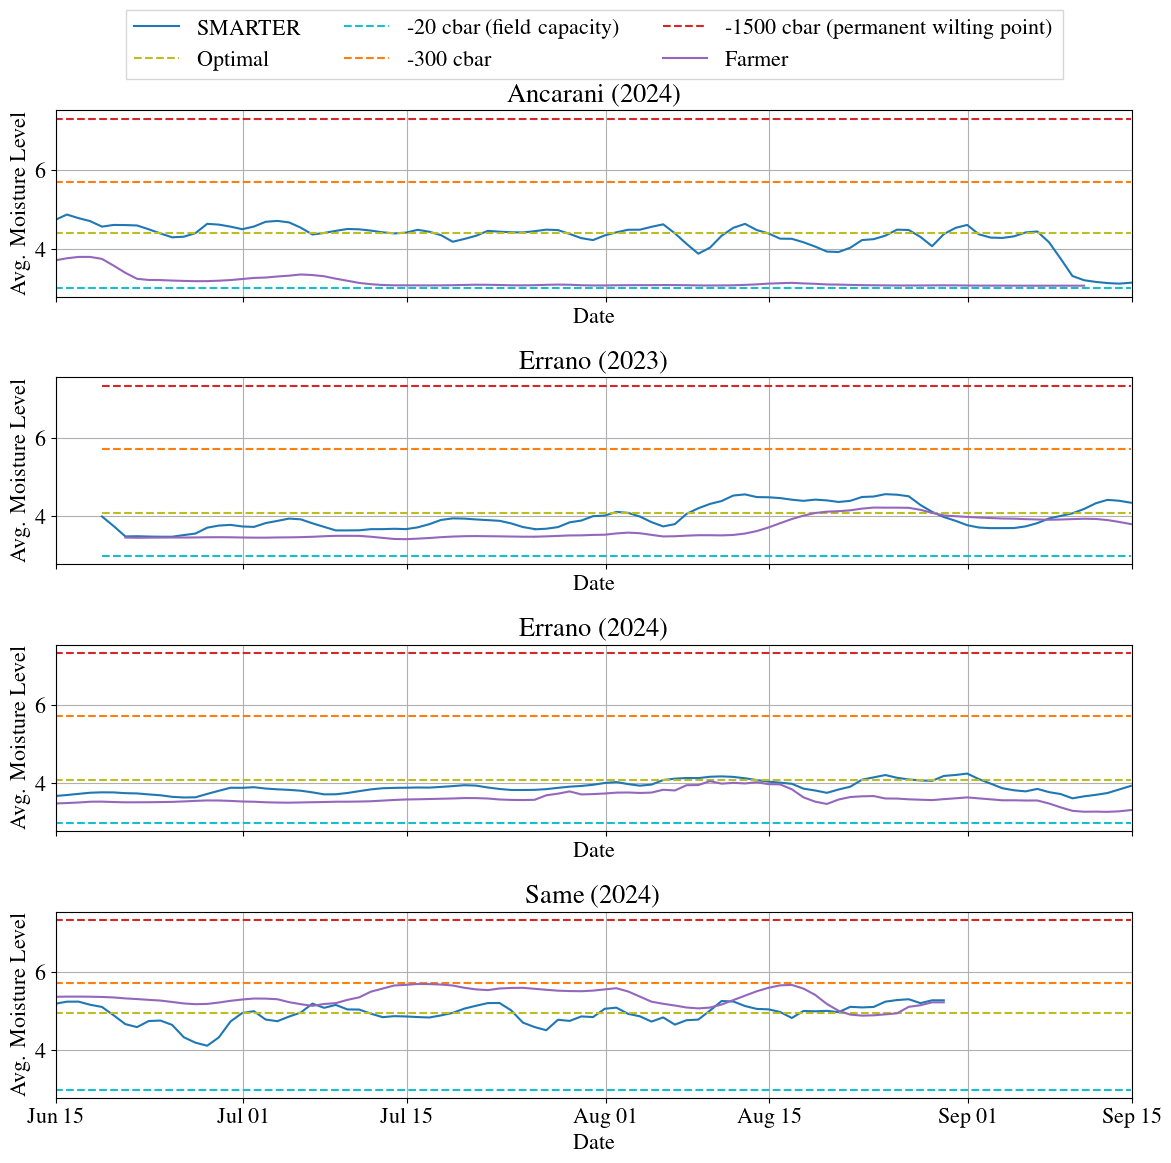

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import log as ln
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

l = [("Ancarani (2024)", 'ancarani_attuale_ottimo_T0_T1-1.csv'), ("Errano (2023)", "errano_ottimo_media_pesata_2023.csv"), ("Errano (2024)", 'errano_attuale_ottimo_media_pesata_2024.csv'), ("Same (2024)", 'same_attuale_ottimo_tutti.csv'), ]# ]
fig, axs = plt.subplots(len(l), 1, figsize=(12, 3 * len(l)), sharex=True, sharey=True)  # Adjust the figure size as needed
for i, s in enumerate(l):
  title, file = s[0], s[1]
  if len(l) > 1: ax = axs[i]
  else: ax = axs
  df = pd.read_csv('/home/field_data/' + file)
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')  # Convert the 'timestamp' column to datetime objects

  if "Errano (2023)" in title:
    df['timestamp'] = df['timestamp'] + pd.Timedelta(days=365)
    df = df[(df['plantRow'] == 'T0') | (df['plantRow'] == 'T1 basso')]
    df.loc[((df['timestamp'] > '2024-08-26') & (df['timestamp'] < '2024-08-27')) & (df['plantRow'] == 'T1 basso'), 'actual'] = np.nan
    df.loc[((df['timestamp'] > '2024-07-22') & (df['timestamp'] < '2024-07-23')) & (df['plantRow'] == 'T1 basso'), 'actual'] = np.nan
  elif title=="Errano (2024)":
    df = df[(df['plantRow'] == 'T0') | (df['plantRow'] == 'T1 basso')]
    df.loc[((df['timestamp'] > '2024-07-28') & (df['timestamp'] < '2024-07-30')) & (df['plantRow'] == 'T0'), 'actual'] = np.nan
  elif title=="Ancarani (2024)":
    df = df[(df['plantRow'] == 'T0 alto') | (df['plantRow'] == 'T1 alto')]
  elif title == "Same (2024)":
    df = df.drop(df[(df['timestamp'] < '2024-07-24') & (df['plantRow'] == "T1 alto")].index)
    df = df.drop(df[(df['timestamp'] >= '2024-07-24') & (df['plantRow'] == "T1 basso")].index)
    df["plantRow"] = df["plantRow"].replace({"T1 basso": "T1 alto"})
    df = df[(df['plantRow'] == 'T1 alto') | (df['plantRow'] == 'T0 basso')]
    df.loc[(df['timestamp'] > '2024-08-28'), 'actual'] = np.nan
  df = df.sort_values(['plantRow', 'timestamp'])  # Sort the DataFrame by timestamp
  impute_with_rolling_average(df, 'actual')
  rolling(df, window_size=3)
  # df = df.dropna()
  df = df[(df['timestamp'] >= '2024-06-14') & (df['timestamp'] <= '2024-09-15')]
  df["Field capacity"] = ln(np.abs(-20))
  df["Dry"] = ln(np.abs(--300))
  df["Very dry"] = ln(np.abs(-1500))

  df["plantRow"] = df["plantRow"].replace({"T0 alto": "Farmer", "T0 basso": "Farmer", "T0": "Farmer", "T1 alto": "SMARTER", "T1 basso": "SMARTER"})

  ax.set_title(title)
  df['r_abs'] = (df['optimal'] - df['actual']).abs()
  df['r'] = (df['optimal'] - df['actual'])
  df_grouped = df.groupby(['plantRow'])[["r", "r_abs", "optimal", "actual"]].mean().reset_index()
  df_grouped["avg_cbar"] = np.e ** (df_grouped['actual'])
  df_grouped["optimal_cbar"] = np.e ** (df_grouped['optimal'])
  print(f"\n\n{title}")
  print(df_grouped)

  for plantRow in ['SMARTER', 'Farmer']: # df['plantRow'].unique():
      df_plantRow = df[df['plantRow'] == plantRow] # .dropna()
      ax.plot(df_plantRow['timestamp'], df_plantRow['actual'], label=plantRow, color="tab:blue" if plantRow == "SMARTER" else "tab:purple")
      if plantRow == "SMARTER":
      #  color =
        df_plantRow['optimal'] = df_plantRow['optimal'].iloc[0]
        ax.plot(df_plantRow['timestamp'], df_plantRow['optimal'], label=f'Optimal', color="tab:olive", ls="--")
        ax.plot(df_plantRow['timestamp'], df_plantRow['Field capacity'], label=f'-20 cbar (field capacity)', color="tab:cyan", ls="--")
        ax.plot(df_plantRow['timestamp'], df_plantRow['Dry'], label=f'-300 cbar', color="tab:orange", ls="--")
        ax.plot(df_plantRow['timestamp'], df_plantRow['Very dry'], label=f'-1500 cbar (permanent wilting point)', color="tab:red", ls="--")
      # else:
      #  color = "tab:red"
  ax.set_xlabel('Date')
  ax.set_xlim([ax.get_xticks()[0], ax.get_xticks()[-1]])
  ax.set_ylabel('Avg. Moisture Level')  # Replace with the appropriate label for your data
  if i == 0: ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=3, fancybox=False, shadow=False)
  # Format x-axis to show Month and Day (e.g., Jan 01)
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
  ax.grid(True)

# plt.xticks(rotation=0, ha="right", rotation_mode="anchor")
fig.tight_layout(rect=[0, 0, 1, 1]) 

save(fig, "opt_vs_act", persist=persist)



Ancarani (2024)

\begin{tabular}{llrrrr}
\toprule
 & key & T0 alto Advice & T0 alto Dripper & T1 alto Advice & T1 alto Dripper \\
field & year &  &  &  &  \\
\midrule
Ancarani & 2024 & 6 & 410 & 370 & 339 \\
\cline{1-6}
\bottomrule
\end{tabular}



Errano (2024)

\begin{tabular}{llrrr}
\toprule
 & key & T0 Dripper & T1 basso Advice & T1 basso Dripper \\
field & year &  &  &  \\
\midrule
Errano & 2024 & 787 & 557 & 670 \\
\cline{1-5}
\bottomrule
\end{tabular}



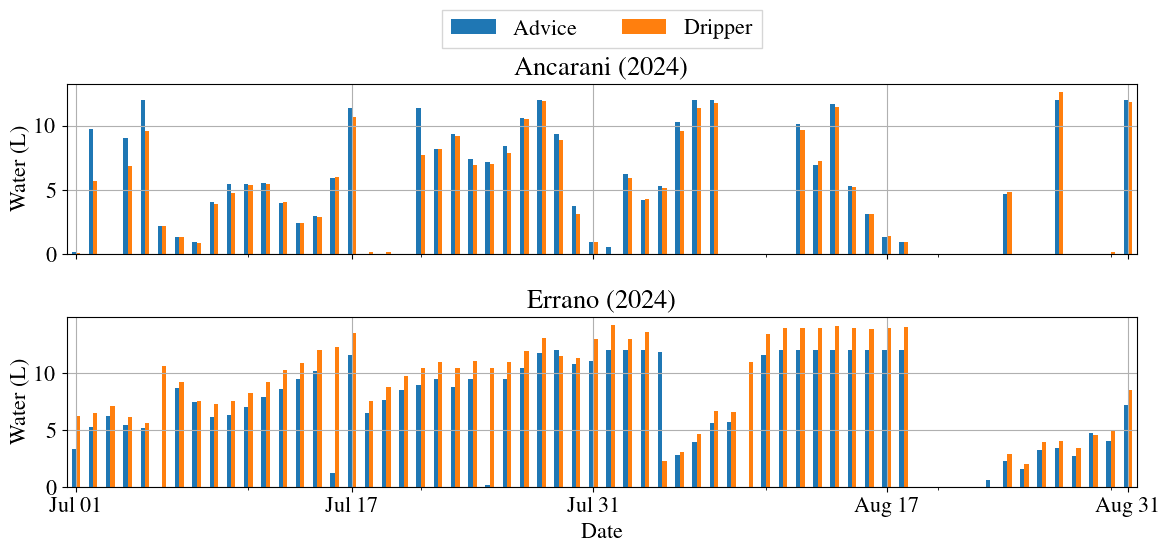

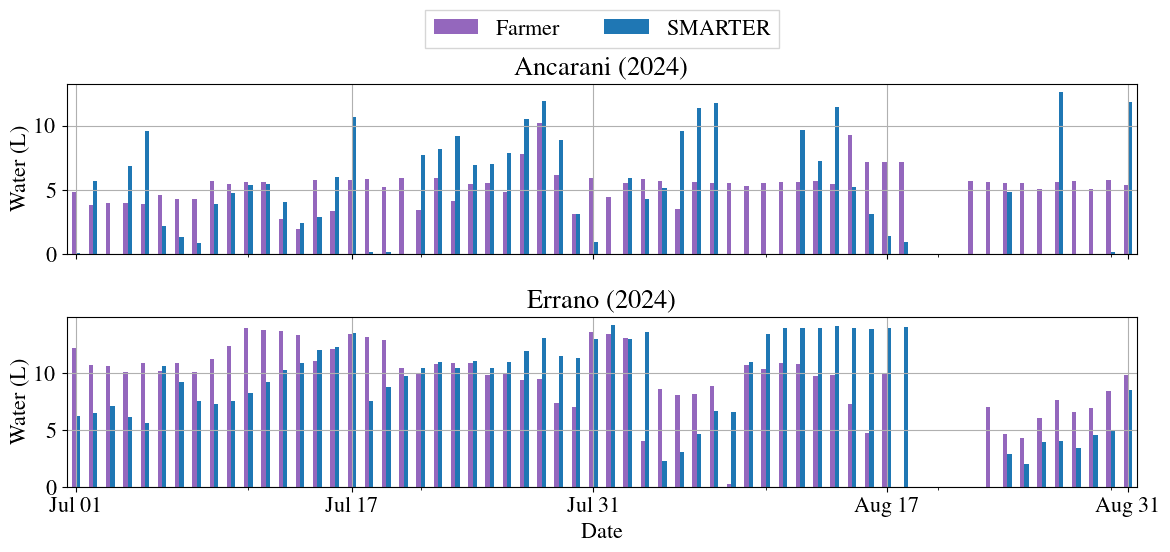

In [194]:
# prompt: read and print ancarani_dripper_advice_pluv_T0_T1.csv, keep only plantRow = "T1 alto", drop rows with detectedValueTypeId = "PLUV_CURR", create a grouped bar chart by timestamp and detectedValueTypeId. keep only timestamps from jun 1 to october 1. aggregate timestamp by day. only show ticks every 14 days
import pandas as pd
import matplotlib.pyplot as plt

l = [
    ("Ancarani (2024)", 'ancarani_dripper_advice_pluv_T0_T1.csv'),
    # ("Errano (2023)", 'errano_dripper_advice_T0_T1_2023.csv'),
    ("Errano (2024)", 'errano_dripper_advice_pluv_T0_T1_2024.csv'),
    # ("Same (2024)", 'same_dripper_advice_pluv.csv')
]
fig, axs = plt.subplots(len(l), 1, figsize=(12, 3 * len(l)), sharex=True)  # Adjust the figure size as needed
fig2, axs2 = plt.subplots(len(l), 1, figsize=(12, 3 * len(l)), sharex=True)  # Adjust the figure size as needed
for i, s in enumerate(l):
  title, file = s[0], s[1]
  if len(l) > 1:
    ax = axs[i]
    ax2 = axs2[i]
  else:
    ax = axs
    ax2 = axs2
  # Assuming your CSV file is named 'ancarani_dripper_advice_pluv_T0_T1.csv'
  df = pd.read_csv('/home/field_data/' + file)
  # Convert the 'timestamp' column to datetime objects
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
  # Drop rows with detectedValueTypeId = "PLUV_CURR"
  df = df[df['detectedValueTypeId'] != 'PLUV_CURR']
  # Filter for timestamps between June 1st and October 1st
  if "Errano (2023)" in title:
    df['timestamp'] = df['timestamp'] + pd.Timedelta(days=365)
  if title == "Ancarani (2024)":
    df.loc[(df['timestamp'] == '2024-06-01') & (df['detectedValueTypeId'] == 'DRIPPER'), 'value'] = 0
  elif title == "Same (2024)":
    df = df.drop(df[(df['timestamp'] < '2024-07-24') & (df['plantRow'] == "T1 alto")].index)
    df = df.drop(df[(df['timestamp'] >= '2024-07-24') & (df['plantRow'] == "T1 basso")].index)
    df["plantRow"] = df["plantRow"].replace({"T1 basso": "T1 alto"})
  df = df[(df['timestamp'] >= '2024-06-15') & (df['timestamp'] <= '2024-09-15')]
  df["detectedValueTypeId"] = df["detectedValueTypeId"].replace({"DRIPPER": "Dripper", "ADVICE": "Advice"})
  #
  print(f"\n\n{title}\n")
  df_grouped = df.groupby(['plantRow', 'detectedValueTypeId'])['value'].sum().astype(int).reset_index()
  df_grouped = df_grouped.drop(df_grouped[(df_grouped['plantRow'].apply(lambda x: "T0" in x)) & (df_grouped['detectedValueTypeId'] == "ADVICE")].index)
  df_grouped["key"] = df_grouped["plantRow"] + " " + df_grouped["detectedValueTypeId"]
  df_grouped = df_grouped[["key", "value"]]
  df_grouped["field"] = title.split(" ")[0]
  df_grouped["year"] = title.split(" ")[1][1:-1]
  df_grouped = df_grouped.pivot(index=['field', 'year'], columns='key', values='value')
  print(df_grouped.to_latex(index=True))

  df = df[(df['timestamp'] >= '2024-07-1') & (df['timestamp'] <= '2024-08-31')]
  df['timestamp'] = df['timestamp'].dt.date
  if title == "Ancarani (2024)":
    df = df[(df['plantRow'] == 'T0 alto') | (df['plantRow'] == 'T1 alto')]
    df["plantRow"] = df["plantRow"].replace({"T0 alto": "Farmer", "T1 alto": "SMARTER"})
  elif "Errano" in title:
    df = df[(df['plantRow'] == 'T1 basso') | (df['plantRow'] == 'T0')]
    df["plantRow"] = df["plantRow"].replace({"T0": "Farmer", "T1 basso": "SMARTER"})
  elif title == "Same (2024)":
    df = df[df['plantRow'] == 'T1 alto']
  df["detectedValueTypeId"] = df["plantRow"].astype(str) + " " + df["detectedValueTypeId"].astype(str)
  df = df[df["detectedValueTypeId"] != "Farmer Advice"]

  for filter, ax in zip(["SMARTER", "Dripper"], [ax, ax2]):
    df_grouped = df[df['detectedValueTypeId'].apply(lambda x: filter in x)].copy(deep=True)
    df_grouped['detectedValueTypeId'] = df_grouped['detectedValueTypeId'].apply(lambda x: x.replace("SMARTER ", "") if filter == "SMARTER" else x.replace(" Dripper", ""))
    df_grouped = df_grouped.groupby(['timestamp', 'detectedValueTypeId'])['value'].sum().unstack()
    df_grouped.plot(kind='bar', ax=ax, legend=False, color=["tab:purple", "tab:blue"] if filter == "Dripper" else ["tab:blue", "tab:orange",])
    if i == 0: ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=3, fancybox=False, shadow=False)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water (L)')
    ax.set_title(title)
    ax.grid(True)
    # ticks_loc = ax.get_xticks()[::14]
    ticks_loc = [ax.get_xticks()[0], ax.get_xticks()[16], ax.get_xticks()[30], ax.get_xticks()[47], ax.get_xticks()[61]]#, ax.get_xticks()[78], ax.get_xticks()[92]]
    ax.set_xticks(ticks_loc)
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.set_xticklabels([str(df_grouped.index[i]).replace("2024-06-", "Jun ").replace("2024-07-", "Jul ").replace("2024-08-", "Aug ").replace("2024-09-", "Sep ") for i in ticks_loc], rotation=0)  #, ha="right", rotation_mode="anchor"


fig.tight_layout()
fig2.tight_layout()
save(fig, "advice_vs_dripper", persist)
save(fig2, "farmer_vs_dripper", persist)